In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from random import sample
from scipy import stats
np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline
# libraries and data
import seaborn as sns
import pandas as pd
plt.style.use('seaborn')

params = {
    'encoder_layers': [128],               
    'decoder_layers': [4],                
    'digit_classification_layers': [128],  
    'activation': tf.nn.sigmoid,            
    'decoder_std': 0.5,                     
    'z_dim': 2,                            
    'digit_classification_weight': 10.0,    
    'epochs': 20,
    'batch_size': 100,
    'learning_rate': 0.001
}
digit_to_learn = 9
num_digits = 10
input_size = 28 * 28
mnist = input_data.read_data_sets('MNIST_data')


def frange_list(start, stop, step=1.0):
    _list = []
    ''' "range()" like function which accept float type''' 
    i = start
    while i < stop:
        _list.append(i)
        i += step
    return _list    

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, proj=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

In [3]:
#get all the digits that are six
digit_images= []
for i in range (int(mnist.train.num_examples)):
    if(mnist.train.labels[i] == digit_to_learn):
        digit_images.append(mnist.train.images[i])

digit_images_test= []
for i in range (int(mnist.test.num_examples)):
    if(mnist.test.labels[i] == digit_to_learn):
        digit_images_test.append(mnist.test.images[i])


In [4]:
'''
from sklearn.decomposition import PCA
pca = PCA(0.85, whiten=True)
data = pca.fit_transform(np.asarray(digit_images))
isomap_dims = data.shape[1]
isomap_dims'''

'\nfrom sklearn.decomposition import PCA\npca = PCA(0.85, whiten=True)\ndata = pca.fit_transform(np.asarray(digit_images))\nisomap_dims = data.shape[1]\nisomap_dims'

In [5]:
'''
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
digit_images_tsne = tsne.fit_transform(digit_images)
digit_images_test_tsne = tsne.fit_transform(digit_images_test)
'''

'\nfrom sklearn.manifold import TSNE\n\ntsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)\ndigit_images_tsne = tsne.fit_transform(digit_images)\ndigit_images_test_tsne = tsne.fit_transform(digit_images_test)\n'

In [6]:
from sklearn.manifold import Isomap
isomap_dims = 2
iso = Isomap(n_components = isomap_dims)

iso = iso.fit(digit_images)
 
digit_images_isomap = iso.transform(digit_images)

digit_images_test_isomap = iso.transform(digit_images_test)

# Dataset:
df=pd.DataFrame({'dim1':digit_images_isomap[:,0],'dim2':digit_images_isomap[:,1]})




In [7]:
digit_images_isomap_normalized = stats.zscore(digit_images_isomap)
# Dataset:
df_normalized=pd.DataFrame({'dim1':digit_images_isomap_normalized[:,0],'dim2':digit_images_isomap_normalized[:,1]})
#df_normalized

In [8]:
xlabels = frange_list(df_normalized['dim1'].min(), df_normalized['dim1'].max(), ((df_normalized['dim1'].max() - df_normalized['dim1'].min())/10))
ylabels = frange_list(df_normalized['dim2'].min(), df_normalized['dim2'].max(), ((df_normalized['dim2'].max() - df_normalized['dim2'].min())/10))

#reverse the ylables so that way the -ve numbers come after +ve numbers to look like the Graph Y axis lables
ylabels = ylabels[::-1]


animation_isomap = []
i=0
j=0
while i < 10:
    j=0 
    animation_isomap_all_yvals_for_single_xval = []
    while j < 10:
        animation_isomap_all_yvals_for_single_xval.append([xlabels[i],ylabels[j]])
        j = j +1
    animation_isomap.append(animation_isomap_all_yvals_for_single_xval)    
    i = i +1 

In [9]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


In [10]:
def plot_samples(samples):
    IMAGE_WIDTH = 0.7
    plt.figure(figsize=(IMAGE_WIDTH * num_digits,len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),num_digits,epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)),cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),verticalalignment='center',horizontalalignment='right',rotation=0,fontsize=14)
            else:
                plt.gca().yaxis.set_visible(False)

In [11]:
def plot_samples_a(samples,xlabels,ylabels):
    IMAGE_WIDTH = 0.7
    plt.figure(figsize=(IMAGE_WIDTH * len(samples[0]),len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),num_digits,epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)),cmap='Greys_r')
            if digit == 0:
                plt.gca().yaxis.set_ticks([]) 
                plt.ylabel("{0:.2f}".format(round(ylabels[epoch],2)),verticalalignment='center',horizontalalignment='right',rotation=0,fontsize=10)
            else:    
                plt.gca().yaxis.set_visible(False)
            
            if epoch == len(samples)-1:
                plt.gca().xaxis.set_ticks([])
                plt.xlabel("{0:.2f}".format(round(xlabels[digit],2)),verticalalignment='top',horizontalalignment='center',rotation=90,fontsize=10)
            else:    
                plt.gca().xaxis.set_visible(False)   
            #print (epoch,digit)
            
            


In [26]:
#TensorFlow Computational Graph
images = tf.placeholder(tf.float32, [None, input_size])
isomap_vals = tf.placeholder(tf.float32, [None,isomap_dims ])

# encode an image into a distribution over the latent space
encoder_mu, encoder_var = encoder(images,params['encoder_layers'])

# sample a latent vector from the latent space - using the reparameterization trick
eps = tf.random_normal(shape=[tf.shape(images)[0],params['z_dim']],mean=0.0,stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps




# penalize the vae-z values if they differ from the isomap values
z_vae_vs_isomap_diff = isomap_vals - z

# decode the latent vector - concatenated to the digits classification - into an image
decoded_images = decoder(z,params['decoder_layers'])


# the loss is composed of how well we can reconstruct the image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)


loss_prior = -0.5 * tf.reduce_sum(1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,axis=1)

loss_auto_encode = tf.reduce_mean(loss_reconstruction + loss_prior,axis=0)

# digit_classification_weight is used to weight between the two losses,
# since there's a tension between them
loss_match_isomap = tf.multiply(
    tf.abs(
        tf.divide(
            tf.reduce_sum(z_vae_vs_isomap_diff),
            tf.to_float(
                tf.shape(images)[0],
                name='ToFloat'
            ),
            name='iso_loss'
        )
    ),
    392,
    name ='rescaled_isomap_loss'
)

loss = loss_auto_encode + loss_match_isomap

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [31]:
samples = []
samples_test = []
animation_samples = []
losses_auto_encode = []
losses_match_isomap = []
digit_images_isomap_normalized = stats.zscore(digit_images_isomap)
digit_images_test_isomap_normalized = stats.zscore(digit_images_test_isomap)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        i = 0
        for _ in range (int(len(digit_images_isomap) / params['batch_size'])):
            batch_images = digit_images[i:i+params['batch_size']]
            batch_isomap_vals = digit_images_isomap_normalized[i:i+params['batch_size']]
            sess.run(train_op, feed_dict={images: batch_images, isomap_vals: batch_isomap_vals})
        
        train_loss_auto_encode, train_loss_match_isomap = sess.run([loss_auto_encode,loss_match_isomap],
                                                {images: digit_images, isomap_vals: digit_images_isomap_normalized})
        
        losses_auto_encode.append(train_loss_auto_encode)
        
        losses_match_isomap.append(train_loss_match_isomap)
        
        #Generate Samples on Training Data
        gen_samples = sess.run(decoded_images,feed_dict={z: digit_images_isomap_normalized[1:10]})
        samples.append(gen_samples)
        #Generate Samples on Testing Data
        gen_samples_test = sess.run(decoded_images,feed_dict={z: digit_images_test_isomap_normalized[1:10]})
        samples_test.append(gen_samples_test)
    j=0
    while j < 10:
        #print(j,epoch, animation_isomap[j])
        animation_samples.append(sess.run(decoded_images,feed_dict={z:animation_isomap[j]}))
        j = j +1 

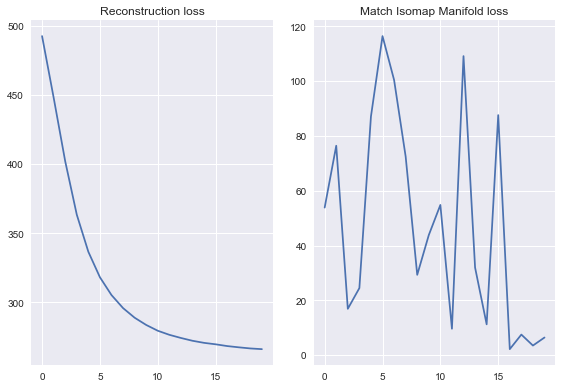

In [32]:

plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('Reconstruction loss')

plt.subplot(122)
plt.plot(losses_match_isomap)
plt.title('Match Isomap Manifold loss')

plt.tight_layout()

In [ ]:
# plot
plt.plot( 'dim1', 'dim2', data=df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of dim1')
plt.ylabel('Value of dim2')
plt.title('Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=df.dim1, y=df.dim2, kind='kde')


In [ ]:
df.describe()

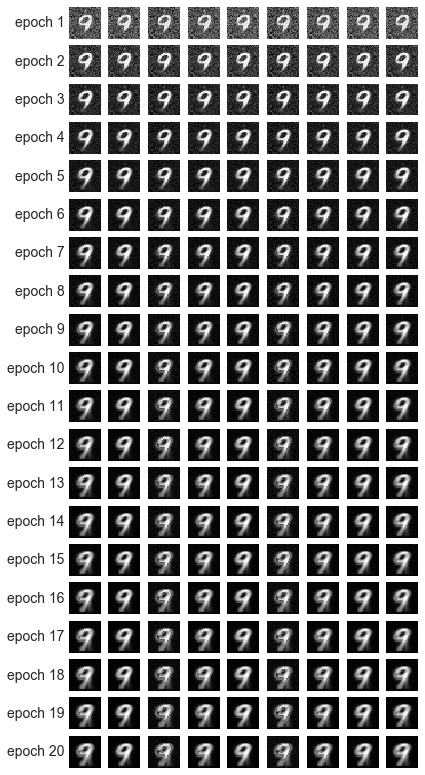

In [29]:
plot_samples(samples)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_components=2)
data = np.array(digit_images)
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                proj=digit_images_isomap, ax=ax, thumb_frac=0.05, cmap='gray_r')

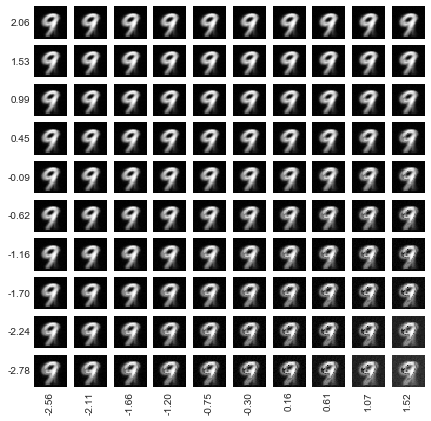

In [33]:
plot_samples_a(animation_samples,xlabels,ylabels)

In [ ]:
animation_isomap

In [ ]:
# Dataset:
df=pd.DataFrame({'dim1':digit_images_test_isomap[:,0],'dim2':digit_images_test_isomap[:,1]})

# plot
plt.plot( 'dim1', 'dim2', data=df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of dim1')
plt.ylabel('Value of dim2')
plt.title('Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=df.dim1, y=df.dim2, kind='kde')

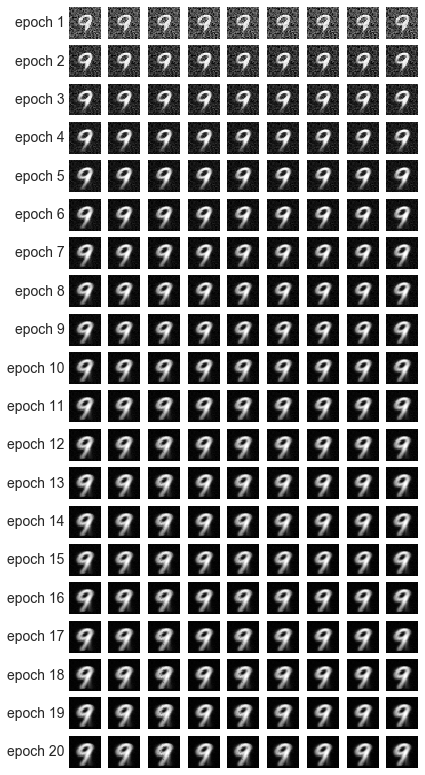

In [21]:
plot_samples(samples_test)

In [ ]:
#Explained variance
pca = PCA().fit(digit_images)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()